In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from numpy import mean, std
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import randint

import xgboost as xgb
import lightgbm as lgb

from joblib import dump

In [6]:
#use given csv data for the model
data = pd.read_csv("../../../data/FelixRot_cleaned/felixstowe_rotterdam_clean_new.csv", on_bad_lines="warn")
print('Data read done')

#specify test features
test_features = [ "COG", "TH", "shiptype", "EndLongitude", "EndLatitude", "pastTravelTime"]
print('Specify test features done')

#specify test and training sets
#Random state is used for initializing the internal random number generator, which will decide the splitting of data into train and test indices
y = data["timeTillArrival"]
X = data[["Latitude", "Longitude", "SOG"] + test_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('Spliting data done')

/var/folders/z9/njt1lp_56q16kwbghjpwd4qm0000gn/T/ipykernel_65020/1774901892.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../../../data/FelixRot_cleaned/felixstowe_rotterdam_clean_new.csv", on_bad_lines="warn")


Data read done
Specify test features done
Spliting data done


In [7]:
#Initializing models
model1 = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
model2 = ExtraTreesRegressor(n_estimators=450, min_samples_split=2, min_samples_leaf=2, max_depth=21, random_state=42)
model3 = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=25, min_child_weight=3, subsample=0.8, colsample_bytree=0.8, gamma=0.1, reg_alpha=0.1, reg_lambda=0.1, objective='reg:squarederror', random_state=42)

# Meta model
meta_model = ExtraTreesRegressor(n_estimators=400, min_samples_split=2, min_samples_leaf=2, max_depth=20, random_state=42)
print('Initializing models done')

#K-fold Cross-Validation: Divide dataset into k equally sized folds (subsets) to reduce variance and better utilize the data
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
print('K-Folds done')

#Arrays to store predictions
x1_train = np.zeros((X_train.shape[0],))
x2_train = np.zeros((X_train.shape[0],))
x3_train = np.zeros((X_train.shape[0],))

x1_test = np.zeros((X_test.shape[0], n_splits))
x2_test = np.zeros((X_test.shape[0], n_splits))
x3_test = np.zeros((X_test.shape[0], n_splits))
print('Initializing Arrays done')

Initializing models done
K-Folds done
Initializing Arrays done


In [8]:
#Collect out-of-fold predictions for the training set
#For each fold, train base models and make predictions on validation set and store them in the arrays

for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(X_train)):
    #Training base models
    model1.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    model2.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    model3.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    print(f'Fiting base models done for fold {fold_idx + 1}')

    #Making predictions
    x1_train[valid_idx] = model1.predict(X_train.iloc[valid_idx])
    x2_train[valid_idx] = model2.predict(X_train.iloc[valid_idx])
    x3_train[valid_idx] = model3.predict(X_train.iloc[valid_idx])
    print(f'Predictins base models done for fold {fold_idx + 1}')

    #Collecting test set predictions for averaging later
    x1_test[:, fold_idx] = model1.predict(X_test)
    x2_test[:, fold_idx] = model2.predict(X_test)
    x3_test[:, fold_idx] = model3.predict(X_test)
    print(f'Collecting test predictions done for fold {fold_idx + 1}')

#Average the test set predictions
x1_test = x1_test.mean(axis=1)
x2_test = x2_test.mean(axis=1)
x3_test = x3_test.mean(axis=1)
print('Averaging test set predictions done')

#Stack predictions as new feature set for meta model
X_train_meta = np.column_stack((x1_train, x2_train, x3_train))
X_test_meta = np.column_stack((x1_test, x2_test, x3_test))
print('Stack predictions as new features set for meta model done')

Fiting base models done for fold 1
Predictins base models done for fold 1
Fiting base models done for fold 2
Predictins base models done for fold 2
Fiting base models done for fold 3
Predictins base models done for fold 3
Fiting base models done for fold 4
Predictins base models done for fold 4
Fiting base models done for fold 5
Predictins base models done for fold 5
Averaging test set predictions done
Stack predictions as new features set for meta model done


In [9]:
#Train meta model
meta_model.fit(X_train_meta, y_train)
print('Train meta model done')

#Make final predictions
final_predictions = meta_model.predict(X_test_meta)
print('Final Prediction done')

#Evaluate the model (Perfect MAE = 0)
#Give out MAE of the prediction set compared to the test set
#MAE in minutes
mse = mean_absolute_error(y_test, final_predictions)
print('Mean absolute Error for Extra Trees: ' , mse/60)
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print('Mean squared Error for Extra Trees: ', rmse)

#feature names for stacked features
stacked_features = ['x1_train', 'x2_train', 'x3_train']
importances = meta_model.feature_importances_
#features = X.columns

Train meta model done
Final Prediction done
Mean absolute Error for Extra Trees:  12.339087663629929
Mean squared Error for Extra Trees:  1600.6229649620745


Creating DataFrame done


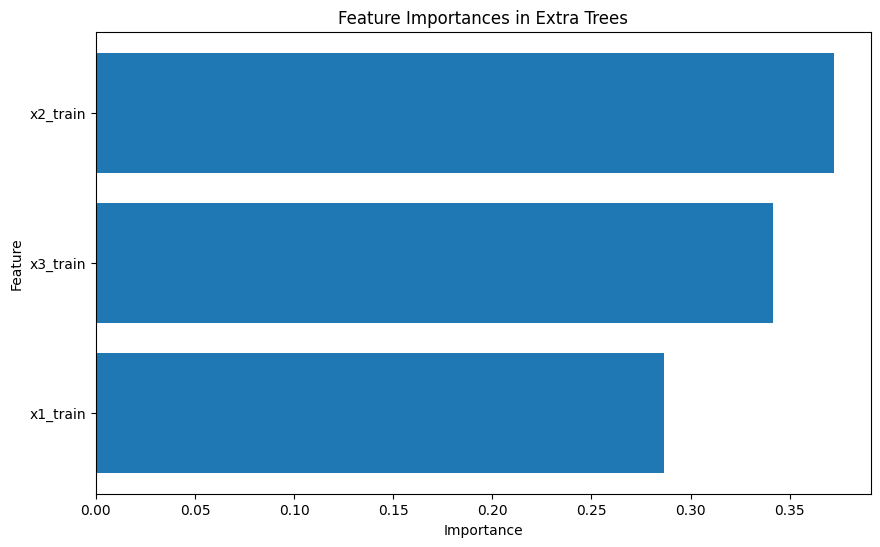

Plotting feature importance done
Graphing done


In [10]:
#Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': stacked_features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print('Creating DataFrame done')

#Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Extra Trees')
plt.gca().invert_yaxis()
plt.show()
print('Plotting feature importance done')

X_train_minimized = X_train.drop(["COG", "TH", "shiptype", "EndLongitude", "EndLatitude", "pastTravelTime"], axis=1)
X_test_minimized = X_test.drop(["COG", "TH", "shiptype", "EndLongitude", "EndLatitude", "pastTravelTime"], axis=1)
print('Graphing done')

In [11]:
#Save the models with Joblib
dump(model1, 'model1.joblib', compress=3)
dump(model2, 'model2.joblib', compress=3)
dump(model3, 'model3.joblib', compress=3)
dump(meta_model, 'meta_model.joblib', compress=3)

['meta_model.joblib']